## 3.3. Предсказание времени прибытия транспортных средств с помощью методов машинного обучения

Данный программный код предназначен для анализа маршрутов движения с временными метками. В таких задачах часто требуется предсказать оставшееся время до завершения маршрута на основе текущих координат и пройденного пути. Это актуально для навигационных систем, логистики, мониторинга транспорта и других областей, где важно оценивать время прибытия.

Основная идея заключается в использовании машинного обучения для построения модели, которая на основе исторических данных о маршрутах сможет предсказывать оставшееся время движения. Код включает полный цикл: загрузку и предобработку данных, обучение модели, оценку качества предсказаний и сохранение результатов.

### 1. Импорт библиотек и модулей

Основная цель:
Обеспечить доступ к необходимым инструментам для работы с данными, машинного обучения и оценки результатов.

1. import pandas as pd
Импорт библиотеки Pandas для работы с табличными данными (DataFrame)
Псевдоним pd является стандартным соглашением

2. import numpy as np
Импорт библиотеки NumPy для математических операций и работы с массивами
Псевдоним np является стандартным соглашением

3. from sklearn.ensemble import RandomForestRegressor
Импорт модели Random Forest для задач регрессии из библиотеки scikit-learn
Будет использоваться для предсказания оставшегося времени

4. from sklearn.preprocessing import StandardScaler
Импорт инструмента для стандартизации данных (приведение к единому масштабу)
Необходим для нормализации признаков перед обучением модели

5. from sklearn.metrics import mean_absolute_error
Импорт метрики MAE (Mean Absolute Error) для оценки качества предсказаний
Позволит измерить среднюю абсолютную ошибку в секундах

Результат:

После выполнения этих импортов становятся доступны все необходимые инструменты для реализации обработки данных и машинного обучения.

In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

### 2. Загрузка данных

Цель выполнения следующего фрагмента кода:

Надежная загрузка и первичная проверка данных из CSV-файлов с маршрутной информацией.

Фактическая цель:

Создать функцию, которая:
- загружает данные из CSV-файла с автоматическим определением параметров;
- проверяет наличие обязательных столбцов;
- выполняет базовую очистку данных;
- обрабатывает возможные ошибки с информативными сообщениями.

1. try:

Начало блока обработки исключений для перехвата возможных ошибок.


2. df = pd.read_csv(filepath, sep=None, engine='python', encoding_errors='ignore')

- Загрузка CSV-файла с автоматическим определением разделителя.
- Параметр engine='python' обеспечивает более надежный парсинг.
- encoding_errors='ignore' позволяет пропускать проблемы с кодировкой.


3. df.columns = df.columns.str.strip().str.lower()

- Нормализация названий столбцов: удаление пробелов и приведение к нижнему регистру
- Делает обработку данных независимой от регистра в исходном файле


4. Проверка обязательных столбцов:

required_cols = ['x', 'y', 'time']

missing_cols = [col for col in required_cols if col not in df.columns]

- Определяет, какие из обязательных столбцов отсутствуют в данных
- Выводит информативное сообщение при их отсутствии

5. df = df[required_cols].copy()

- Выбор только нужных столбцов для дальнейшей работы
- Использование .copy() предотвращает предупреждения Pandas о работе с view


6. Проверка на пустые значения

- Выводит статистику по пропущенным значениям
- Удаляет строки с пропусками


7. Обработка исключений

Перехватывает любые ошибки при загрузке и выводит информативное сообщение/


Результат выполнения функции:

- DataFrame с тремя столбцами ('x', 'y', 'time') без пропущенных значений
- None, если возникли критические ошибки при загрузке или проверке данных

In [14]:
def load_data(filepath):
    """Улучшенная загрузка данных с детальной диагностикой"""
    try:
        # 2. Загрузка CSV-файла с автоматическим определением разделителя
        df = pd.read_csv(filepath, sep=None, engine='python', encoding_errors='ignore')
        
        # 3. Нормализация названий столбцов: удаление пробелов и приведение к нижнему регистру
        df.columns = df.columns.str.strip().str.lower()
        
        # 4. Проверка необходимых столбцов
        required_cols = ['x', 'y', 'time']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            print(f"Файл {filepath} не содержит столбцов: {missing_cols}")
            print(f"Фактические столбцы: {df.columns.tolist()}")
            return None
            
        # 5. Выбор только нужных столбцов
        df = df[required_cols].copy()
        
        # 6. Проверка на пустые значения
        if df.isnull().any().any():
            print(f"Файл {filepath} содержит пустые значения:")
            print(df.isnull().sum())
            df = df.dropna()
            
        return df if not df.empty else None
        
        # 7. Обработка исключений
    except Exception as e:
        print(f"Критическая ошибка при загрузке {filepath}: {str(e)}")
        return None

###  3. Подготовка данных

Цель следующей функции заключается в преобразовании сырых данных о координатах и времени в структурированный набор признаков, пригодный для обучения модели машинного обучения.

Фактическая цель:

Создать функцию, которая:

- Принимает DataFrame с сырыми данными (x, y, time).
- Проверяет данные на корректность.
- Преобразует время в числовой формат (секунды).
- Вычисляет дополнительные признаки для модели.
- Удаляет некорректные записи.
- Возвращает обработанный DataFrame или None в случае ошибки.

1. Проверка входных данных

Проверяет, что DataFrame не пустой и не None.

Если данные отсутствуют, функция завершается с сообщением об ошибке.


2. Обработка координат

2.1. Преобразование координат в числовой формат (float)

- Преобразует координаты x и y в числовой формат (float).
- Заменяет запятые на точки (для корректного чтения чисел в европейском формате).
- Некорректные значения (например, текст) заменяются на NaN (errors='coerce').

2.2. Удаление строк с некорректными координатами

- Удаляет строки, где координаты x или y не были преобразованы в число (NaN).
- Выводит количество удаленных строк.

2.3. Если после очистки данных не осталось, функция завершается.


3. Обработка времени

3.1. Попытка разбора времени через pandas

- Разбивает время (формат ЧЧ:ММ:СС) на три компонента: часы, минуты, секунды.
- Если формат не соответствует ЧЧ:ММ:СС, вызывает ошибку.

3.2. Преобразование часов, минут и секунд в числа

- Преобразует часы, минуты и секунды в числа.
- Некорректные значения (например, "12:xx:05") заменяются на NaN.

3.3. Перевод времени в общее количество секунд

3.4. Обработка записей с некорректным временем

- Находит записи с некорректным временем (NaN).
- Выводит примеры ошибочных значений.
- Удаляет строки с некорректным временем.

3.5. Если после обработки данных не осталось, функция завершается.


4. Расчет характеристик маршрута

- end_point — координаты и время последней точки маршрута (финиш).
- start_point — координаты первой точки (старт).

4.1. Определение расстояния от текущей точки до конечной (по формуле расстояния между точками)

4.2. Определение прогресса

Рассчитывает прогресс (progress):
- 0 — точка финиша.
- 1 — точка старта.
- Промежуточные значения — процент пройденного пути.

4.3. Вычисление оставшегося времени

Вычисляет истинное оставшееся время (разница между временем финиша и текущим временем).

4.4. Удаление аномалий

Удаляет аномалии (например, если время в какой-то точке больше, чем время финиша).

4.5. Если после фильтрации данных не осталось, функция завершается.


Результат выполнения функции:


Функция возвращает DataFrame с добавленными признаками:

- x, y — координаты (числовой формат, очищенные от ошибок).
- time_sec — время в секундах.
- distance_to_end — расстояние до конечной точки.
- progress — прогресс прохождения маршрута (от 0 до 1).
- true_remaining_sec — истинное оставшееся время в секундах.

Если на каком-то этапе возникает ошибка или данные становятся пустыми, функция возвращает None с выводом соответствующего сообщения.

In [15]:
def prepare_features(df):
    """Улучшенная подготовка данных с проверкой каждого шага"""
    print("\nНачало обработки данных...")
    
    # 1. Проверка входных данных
    if df is None or df.empty:
        print("Ошибка: Пустые входные данные")
        return None
    
    try:
        # 2. Обработка координат
        print("Обработка координат...")
        
        # 2.1. Преобразование координат в числовой формат (float)
        for col in ['x', 'y']:
            df[col] = pd.to_numeric(
                df[col].astype(str).str.replace(',', '.'), 
                errors='coerce'
            )
        
        # 2.2. Удаление строк с некорректными координатами
        initial_rows = len(df)
        df = df.dropna(subset=['x', 'y'])
        if len(df) < initial_rows:
            print(f"Удалено {initial_rows - len(df)} строк с некорректными координатами")
        
        # 2.3. Если после очистки данных не осталось, функция завершается.
        if df.empty:
            print("Ошибка: Нет данных после обработки координат")
            return None
        
        # 3. Обработка времени
        print("Обработка времени...")
        try:
            # 3.1. Попытка разбора времени через pandas
            time_parts = df['time'].str.split(':', expand=True)
            if time_parts.shape[1] < 3:
                raise ValueError("Неверный формат времени")
            
            # 3.2. Преобразование часов, минут и секунд в числа
            hours = pd.to_numeric(time_parts[0], errors='coerce')
            minutes = pd.to_numeric(time_parts[1], errors='coerce')
            seconds = pd.to_numeric(time_parts[2], errors='coerce')
            
            # 3.3. Перевод времени в общее количество секунд
            df['time_sec'] = hours*3600 + minutes*60 + seconds
            invalid_time = df['time_sec'].isna()
            
            # 3.4. Обработка записей с некорректным временем
            if invalid_time.any():
                print(f"Найдено {invalid_time.sum()} некорректных значений времени. Примеры:")
                print(df[invalid_time][['time']].head())
                df = df[~invalid_time]
            
            # 3.5. Если после обработки данных не осталось, функция завершается.
            if df.empty:
                print("Ошибка: Нет данных после обработки времени")
                return None
                
        except Exception as time_err:
            print(f"Ошибка обработки времени: {str(time_err)}")
            return None
        
        # 4. Расчет характеристик маршрута
        print("Расчет характеристик маршрута...")
        try:
            end_point = df.iloc[-1][['x', 'y', 'time_sec']]
            start_point = df.iloc[0][['x', 'y']]
            
            # 4.1. Определение расстояния от текущей точки до конечной (по формуле расстояния между точками)
            df['distance_to_end'] = np.sqrt((df['x']-end_point['x'])**2 + (df['y']-end_point['y'])**2)
            
            # 4.2. Определение прогресса
            df['progress'] = df['distance_to_end'] / df['distance_to_end'].max()
            
            # 4.3. Вычисление оставшегося времени
            df['true_remaining_sec'] = end_point['time_sec'] - df['time_sec']
            
            # 4.4. Удаление аномалий
            initial_rows = len(df)
            df = df[df['true_remaining_sec'] >= 0]
            if len(df) < initial_rows:
                print(f"Удалено {initial_rows - len(df)} строк с отрицательным временем")
            
            # 4.5. Если после фильтрации данных не осталось, функция завершается.
            if df.empty:
                print("Ошибка: Нет данных после фильтрации аномалий")
                return None
                
            print("Обработка данных успешно завершена")
            return df
            
        except Exception as calc_err:
            print(f"Ошибка расчетов: {str(calc_err)}")
            return None
            
    except Exception as e:
        print(f"Неожиданная ошибка при обработке: {str(e)}")
        return None


### 4. Обучение модели предсказания времени маршрута

Используемая модель: Random Forest (Случайный лес) для регрессии

1. Random Forest (Случайный лес) — это ансамблевая модель машинного обучения, состоящая из множества деревьев решений (Decision Trees). Каждое дерево обучается на случайном подмножестве данных и признаков, а итоговый прогноз формируется как среднее значение предсказаний всех деревьев (для регрессии) или большинство голосов (для классификации).


2. Принцип работы Random Forest.

а) Бутстрэп-агрегирование (Bagging)

- Из обучающей выборки случайно выбираются подмножества данных с повторениями (bootstrap samples).
- На каждом таком подмножестве строится отдельное дерево решений.

б) Случайность в признаках

- При каждом разбиении узла дерева рассматривается не все признаки, а только их случайное подмножество (обычно sqrt(n_features)).

в) Агрегация предсказаний

- Для регрессии: итоговый прогноз — среднее значение предсказаний всех деревьев.
- Для классификации: голосование большинством.

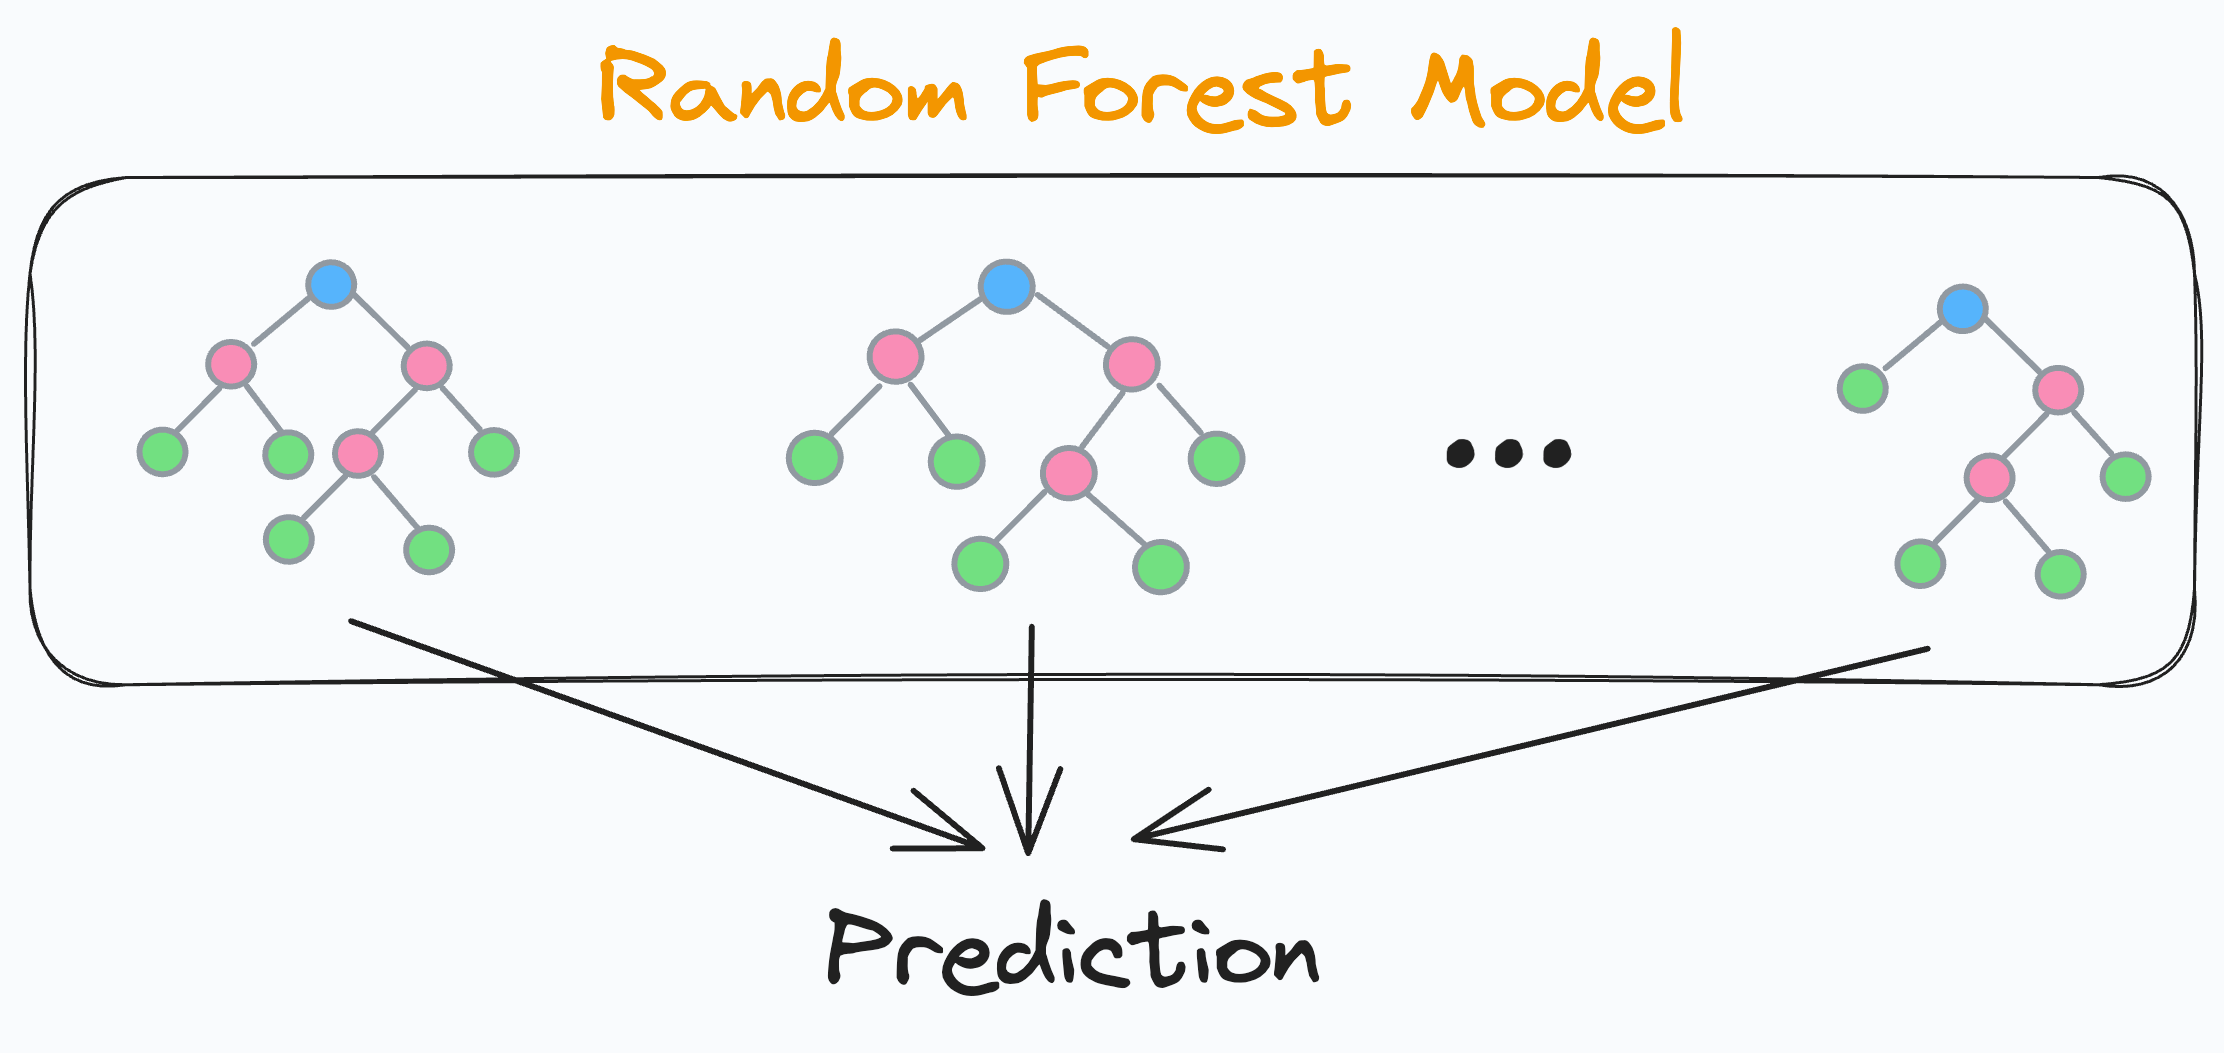

3. Обучение модели (метод fit)

а) Нормализация данных.

- Приводит признаки к стандартному нормальному распределению:

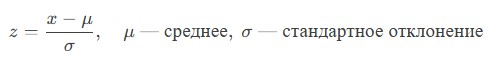

- Улучшает сходимость алгоритма.


б) Построение деревьев:

Для каждого из 200 деревьев:

- Выбирается случайное подмножество данных (с повторениями).
- Дерево строится рекурсивно, начиная с корня:
- На каждом шаге выбирается лучший признак и порог для разбиения, чтобы минимизировать MSE (Mean Squared Error):

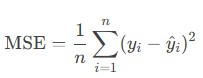

- Разбиение продолжается, пока не достигнута max_depth или min_samples_split.


в) Итоговая модель:

- Ансамбль из 200 деревьев, каждое из которых "голосует" за предсказание.
- Для регрессии прогноз — среднее всех предсказаний:

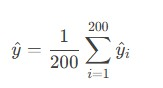

4. Предсказание (метод predict)

Данные нормализуются тем же scaler, что и при обучении.

Каждое дерево делает свое предсказание для каждого тестового образца.

Итоговый прогноз — среднее значение всех 200 предсказаний.


5. Оценка качества (MAE)

MAE (Mean Absolute Error) — средняя абсолютная ошибка:


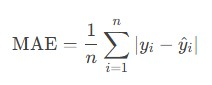

Интерпретация:

Например, MAE = 900 секунд (15 минут) означает, что модель в среднем ошибается на 15 минут.


6. Преимущества Random Forest

а) Устойчивость к переобучению: Благодаря агрегированию множества деревьев.

б) Работа с нелинейными зависимостями: Деревья автоматически捕捉ляют сложные взаимосвязи.

в) Интерпретируемость: Можно оценить важность признаков (model.feature_importances_).

г) Гибкость: Хорошо работает как с числовыми, так и категориальными данными.

7. Математическая основа
Критерий разделения узла (минимизация MSE):
Для каждого разбиения выбирается признак j и порог t, которые минимизируют:

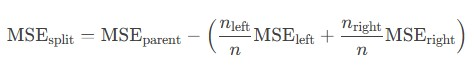

Предметная цель:

Создать и обучить модель машинного обучения (Random Forest), которая предсказывает оставшееся время до завершения маршрута на основе:

- текущих координат (x, y),
- расстояния до конечной точки (distance_to_end),
- прогресса прохождения маршрута (progress).


Фактическая цель:

- Загрузить данные из переданных файлов (train_files - для обучения, test_file - для тестирования).
- Обработать данные (нормализация, вычисление признаков).
- Обучить модель на подготовленных данных.
- Протестировать модель и вывести метрики качества.
- Сохранить предсказания в удобном формате.

1. Загрузка обучающих данных

Для каждого файла в train_files:

- Загружает данные (load_data).
- Обрабатывает их (prepare_features).
- Если данные корректны, добавляет в список train_dfs.

Если ни один файл не загрузился, возвращает None.

Результат:

Список DataFrame (train_dfs) с обработанными данными для обучения.


2. Загрузка тестовых данных

- Загружает и обрабатывает тестовые данные.
- Если возникла ошибка, функция завершается.

Результат:
DataFrame test_df с тестовыми данными, готовыми для предсказания.


3. Подготовка данных для модели

Признаки (features):

- x, y — координаты.
- distance_to_end — расстояние до конца маршрута.
- progress — прогресс (0-1).

Целевая переменная (target): true_remaining_sec (оставшееся время в секундах).

Результат:

- X_train, y_train — данные для обучения.
- X_test — данные для тестирования.


4. Обучение модели

Нормализация данных (StandardScaler): приводит признаки к единому масштабу (среднее = 0, дисперсия = 1).

Random Forest Regressor:

- Ансамбль из 200 деревьев.
- Ограничение глубины (max_depth=10) для предотвращения переобучения.
- Параметр random_state=42 обеспечивает воспроизводимость результатов.

Результат:

Обученная модель model, готовая к предсказаниям.


5. Предсказание и оценка

- Предсказание: модель предсказывает оставшееся время в секундах.
- Конвертация в ЧЧ:ММ для удобства интерпретации.
- MAE (Mean Absolute Error): средняя абсолютная ошибка в секундах (показывает, на сколько минут/часов модель ошибается в среднем).


Результат:

а) test_df с колонками:
- pred_remaining_sec — предсказанное время в секундах.
- true_remaining, pred_remaining — время в формате ЧЧ:ММ.

б) Вывод MAE (например, 00:15 означает, что модель ошибается в среднем на 15 минут).


6. Сохранение результатов

Сохраняет результаты в файл route_predictions.csv:

- Исходное время, координаты.
- Истинное и предсказанное время.

Выводит примеры предсказаний.

Результат:

Файл route_predictions.csv с предсказаниями модели.


Итоговый результат работы функции

- Обученная модель Random Forest, готовая к использованию.
- Файл с предсказаниями (route_predictions.csv).
- Метрика качества (MAE в формате ЧЧ:ММ).
- Вывод первых предсказаний для визуальной проверки.
- Если на любом этапе возникает ошибка (например, нет данных для обучения), функция возвращает None и выводит сообщение об ошибке.

In [19]:
def train_model(train_files, test_file):
    """Полный процесс обучения с улучшенной диагностикой"""
    print("\n=== Начало обучения модели ===")
    
    # 1. Загрузка обучающих данных
    print("\nЗагрузка обучающих данных...")
    train_dfs = []
    for file in train_files:
        print(f"\nОбработка файла: {file}")
        df = load_data(file)
        if df is not None:
            print(f"Загружено строк: {len(df)}")
            prepared = prepare_features(df)
            if prepared is not None:
                print(f"Готово строк после обработки: {len(prepared)}")
                train_dfs.append(prepared)
            else:
                print("Файл не был обработан")
        else:
            print("Файл не был загружен")
    
    if not train_dfs:
        print("\nОшибка: Нет данных для обучения")
        return None
    
    # 2. Загрузка тестовых данных
    print(f"\nЗагрузка тестового файла: {test_file}")
    test_df = load_data(test_file)
    if test_df is None:
        print("Ошибка: Тестовый файл не загружен")
        return None
    
    print(f"Загружено тестовых строк: {len(test_df)}")
    test_df = prepare_features(test_df)
    if test_df is None:
        print("Ошибка: Тестовые данные не были обработаны")
        return None
    
    print(f"Готово тестовых строк после обработки: {len(test_df)}")
    
    # 3. Подготовка данных для модели
    print("\nПодготовка данных для модели...")
    features = ['x', 'y', 'distance_to_end', 'progress']
    target = 'true_remaining_sec'
    
    X_train = pd.concat(train_dfs)[features]
    y_train = pd.concat(train_dfs)[target]
    X_test = test_df[features]
    
    print(f"Обучающая выборка: {X_train.shape}")
    print(f"Тестовая выборка: {X_test.shape}")
    
    # 4. Обучение модели
    print("\nОбучение модели...")
    try:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model = RandomForestRegressor(
            n_estimators=200,
            max_depth=10,
            min_samples_split=5,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train_scaled, y_train)
        print("Обучение завершено")
        
        # 5. Предсказание и оценка
        print("\nОценка модели...")
        test_df['pred_remaining_sec'] = model.predict(X_test_scaled)
        
        # Конвертация секунд в ЧЧ:ММ
        def sec_to_hhmm(seconds):
            return f"{int(seconds//3600):02d}:{int((seconds%3600)//60):02d}"
        
        test_df['true_remaining'] = test_df[target].apply(sec_to_hhmm)
        test_df['pred_remaining'] = test_df['pred_remaining_sec'].apply(sec_to_hhmm)
        
        mae_sec = mean_absolute_error(test_df[target], test_df['pred_remaining_sec'])
        print(f"\nСредняя абсолютная ошибка: {sec_to_hhmm(mae_sec)} (ЧЧ:ММ)")
        
        # 6. Сохранение результатов
        output_cols = ['time', 'x', 'y', 'true_remaining', 'pred_remaining']
        results = test_df[output_cols].copy()
        results.columns = ['Время', 'X', 'Y', 'Фактическое осталось', 'Предсказано осталось']
        
        print("\nПервые 15 предсказаний:")
        print(results.head(15))
        
        results.to_csv('route_predictions.csv', index=False)
        print("\nРезультаты сохранены в route_predictions.csv")
        
        return results
        
    except Exception as e:
        print(f"Ошибка при обучении модели: {str(e)}")
        return None

### 5. Предсказание времени прибытия ТС

Предметная цель фрагмента кода: 

- Демонстрация работы скрипта на конкретных данных.
- Интеграция всех этапов (загрузка данных, обучение модели, оценка результатов) в единый pipeline.
- Обеспечение возможности запуска скрипта как самостоятельной программы (а не только как импортируемого модуля).


Фактическая цель:

- Определить входные данные (тренировочные и тестовые файлы).
- Запустить процесс обучения модели через функцию train_model().
- Обработать результат:

Если успешно — вывести предсказания.
Если возникла ошибка — сообщить об этом пользователю.


1. Блок if __name__ == "__main__":

Код внутри этого блока выполняется только при прямом запуске скрипта (например, через python script.py), но не при импорте этого файла как модуля в другой программе.

Это стандартный подход в Python для разделения "исполняемого" и "импортируемого" кода.


2. Определение путей к данным

- train_files — список CSV-файлов с тренировочными данными.
- test_file — файл с тестовыми данными (actual3_...), на которых будет проверяться модель.

Использование нескольких тренировочных файлов позволяет модели обучаться на разнообразных данных, что улучшает её обобщающую способность.


3. Запуск обучения модели

Вызывает функцию train_model(), передавая ей:

- Список тренировочных файлов.
- Путь к тестовому файлу.

Функция возвращает:

- DataFrame с результатами предсказаний (если всё успешно).
- None (если возникла ошибка на любом этапе).


4. Обработка результата

Если results is None:

- Значит, в процессе работы возникла ошибка (например, не загрузились данные).
- Пользователь увидит сообщение и сможет проверить логи (сообщения об ошибках, которые выводились ранее).

Если успешно:

- Результаты уже сохранены в route_predictions.csv (это делает train_model()).
- На экран выведены первые 15 предсказаний (см. вывод функции train_model()).


Результат:

При успешном выполнении:

- Обученная модель Random Forest.
- Файл route_predictions.csv с предсказаниями для тестовых данных.
- На экране — примеры предсказаний и метрика MAE (например, Средняя абсолютная ошибка: 00:15).

При ошибке:

- Сообщение Не удалось получить результаты. Проверьте логи выше.
В логах будут подробности (например, какой файл не загрузился или какие данные некорректны).

In [20]:
if __name__ == "__main__":
    # 2. Определение путей к данным
    train_files = [
        'Time/ideal_mnogo_to4ek_with_time.csv',
        'Time/actual1_mnogo_to4ek_with_time.csv',
        'Time/actual2_mnogo_to4ek_with_time.csv'
    ]
    
    # Тестовый файл
    test_file = 'Time/actual3_mnogo_to4ek_with_time.csv'
    
    # 3. Запуск обучения модели
    results = train_model(train_files, test_file)
    
    # 4. Обработка результата
    if results is None:
        print("\nНе удалось получить результаты. Проверьте логи выше.")


=== Начало обучения модели ===

Загрузка обучающих данных...

Обработка файла: Time/ideal_mnogo_to4ek_with_time.csv
Загружено строк: 188

Начало обработки данных...
Обработка координат...
Обработка времени...
Расчет характеристик маршрута...
Обработка данных успешно завершена
Готово строк после обработки: 188

Обработка файла: Time/actual1_mnogo_to4ek_with_time.csv
Загружено строк: 169

Начало обработки данных...
Обработка координат...
Обработка времени...
Расчет характеристик маршрута...
Обработка данных успешно завершена
Готово строк после обработки: 169

Обработка файла: Time/actual2_mnogo_to4ek_with_time.csv
Загружено строк: 193

Начало обработки данных...
Обработка координат...
Обработка времени...
Расчет характеристик маршрута...
Обработка данных успешно завершена
Готово строк после обработки: 193

Загрузка тестового файла: Time/actual3_mnogo_to4ek_with_time.csv
Загружено тестовых строк: 291

Начало обработки данных...
Обработка координат...
Обработка времени...
Расчет характери

### 6. Расширенный цикл обучения модели с автоматическим обновлением данных

Предметная цель:

1. Автоматизация процесса обучения:

- Последовательное тестирование на новых данных.
- Динамическое расширение обучающей выборки.

2. Имитация "продукционной" среды:

Модель постепенно улучшается, добавляя проверенные данные в обучение.

3. Обработка серии файлов:

Автоматический переход к следующему тестовому файлу (actual3 → actual4 → ...).


Фактическая цель:

1. Создать самообучающуюся систему. После успешного тестирования добавлять файл в тренировочные данные.

2. Организовать цикличную обработку. Пока есть новые файлы, продолжать обучение.

3. Контролировать целостность данных. Пропускать битые файлы без добавления в выборку.

1. Вспомогательные функции

1.1. Добавление протестированного файла в список обучающих

update_training_data(train_files, tested_file)

Добавляет протестированный файл в список обучающих, если его там еще нет.

Логика:

- Проверяет наличие файла в train_files.
- Если файл новый — добавляет его и выводит сообщение.
- Если уже есть — только уведомляет пользователя.

Результат: Обновленный список train_files.

1.2. Генерация имени следующего тестового файла по шаблону actualN → actualN+1.

Результат:

Имя следующего файла или None, если шаблон не найден.


2. Основной блок (if __name__ == "__main__":)

2.1. Инициализация

Начальные данные:

- train_files: 3 файла (идеальный маршрут + 2 реальных).
- test_file: Первый тестовый файл (actual3).

2.2. Основной цикл обработки

Цель цикла:

Последовательно тестировать файлы, пока они не закончатся.

Вывод статуса:

Количество обучающих файлов и текущий тестовый файл.


2.3. Запуск модели

Вызывает основную функцию обучения.

Возвращает None при ошибке или DataFrame с результатами.

2.4. Обработка результатов

Если успешно (results is not None):

- Добавляет тестовый файл в обучающую выборку.
- Пытается найти следующий файл (actual4, actual5, ...).
- Если файл существует — продолжает цикл, иначе — завершает работу.

Если ошибка (results is None):

- Прерывает цикл без добавления файла.


3. Итоговый список файлов обучающей выборки


Результаты:

Последовательная обработка файлов:

1. Тестирует actual3 → добавляет в обучение → переходит к actual4 → ...

2. Автоматическое расширение данных. После каждого успешного теста выборка увеличивается.

3. Итоговый отчет. Список всех файлов, включенных в финальную обучающую выборку.

4.Если train_model() вернет None (например, из-за битого файла):

- Цикл прервется.
- Файл не добавится в выборку.
- Пользователь увидит сообщение: Пропускаем добавление файла из-за ошибок.


In [21]:
import os


# 1.1. Добавление протестированного файла в список обучающих
def update_training_data(train_files, tested_file):
    """Добавляет протестированный файл в обучающую выборку"""
    # Проверяем, что файл еще не в обучающей выборке
    if tested_file not in train_files:
        train_files.append(tested_file)
        print(f"\nФайл {tested_file} добавлен в обучающую выборку")
    else:
        print(f"\nФайл {tested_file} уже есть в обучающей выборке")
    return train_files

# 1.2. Генерация имени следующего тестового файла по шаблону actualN → actualN+1.
def get_next_test_file(current_test_file):
    """Возвращает следующий файл для тестирования"""
    # Пример: actual3 -> actual4, actual4 -> actual5 и т.д.
    if 'actual' in current_test_file:
        num = int(current_test_file.split('actual')[-1].split('_')[0])
        next_num = num + 1
        return current_test_file.replace(f'actual{num}', f'actual{next_num}')
    return None

# 2. Основной блок
if __name__ == "__main__":
    # 2.1. Инициализация
    train_files = [
        'Time/ideal_mnogo_to4ek_with_time.csv',
        'Time/actual1_mnogo_to4ek_with_time.csv',
        'Time/actual2_mnogo_to4ek_with_time.csv'
    ]
    test_file = 'Time/actual3_mnogo_to4ek_with_time.csv'
    
    # 2.2. Основной цикл обработки
    while True:
        print("\n" + "="*50)
        print(f"Текущая обучающая выборка: {len(train_files)} файлов")
        print(f"Тестируем файл: {test_file}")
        
        # 2.3. Запуск модели
        results = train_model(train_files, test_file)
        
        # 2.4. Обработка результатов
        if results is not None:
            # Обновляем обучающую выборку
            train_files = update_training_data(train_files, test_file)
            
            # Получаем следующий тестовый файл
            next_test_file = get_next_test_file(test_file)
            
            if next_test_file and os.path.exists(next_test_file):
                test_file = next_test_file
            else:
                print("\nДостигнут конец списка файлов или файл не существует")
                print(f"Следующий файл для тестирования: {next_test_file}")
                break
        else:
            print("\nПропускаем добавление файла из-за ошибок")
            break
    
    # 3. Итоговый список файлов обучающей выборки
    print("\nФинальный состав обучающей выборки:")
    for i, file in enumerate(train_files, 1):
        print(f"{i}. {file}")


Текущая обучающая выборка: 3 файлов
Тестируем файл: Time/actual3_mnogo_to4ek_with_time.csv

=== Начало обучения модели ===

Загрузка обучающих данных...

Обработка файла: Time/ideal_mnogo_to4ek_with_time.csv
Загружено строк: 188

Начало обработки данных...
Обработка координат...
Обработка времени...
Расчет характеристик маршрута...
Обработка данных успешно завершена
Готово строк после обработки: 188

Обработка файла: Time/actual1_mnogo_to4ek_with_time.csv
Загружено строк: 169

Начало обработки данных...
Обработка координат...
Обработка времени...
Расчет характеристик маршрута...
Обработка данных успешно завершена
Готово строк после обработки: 169

Обработка файла: Time/actual2_mnogo_to4ek_with_time.csv
Загружено строк: 193

Начало обработки данных...
Обработка координат...
Обработка времени...
Расчет характеристик маршрута...
Обработка данных успешно завершена
Готово строк после обработки: 193

Загрузка тестового файла: Time/actual3_mnogo_to4ek_with_time.csv
Загружено тестовых строк: 

Загружено тестовых строк: 179

Начало обработки данных...
Обработка координат...
Обработка времени...
Расчет характеристик маршрута...
Обработка данных успешно завершена
Готово тестовых строк после обработки: 179

Подготовка данных для модели...
Обучающая выборка: (1021, 4)
Тестовая выборка: (179, 4)

Обучение модели...
Обучение завершено

Оценка модели...

Средняя абсолютная ошибка: 00:09 (ЧЧ:ММ)

Первые 15 предсказаний:
       Время         X         Y Фактическое осталось Предсказано осталось
0   17:13:13  47.21873  39.70276                00:59                00:47
1   17:13:33  47.21833  39.70294                00:59                00:50
2   17:13:53  47.21792  39.70311                00:59                00:46
3   17:14:13  47.21772  39.70320                00:58                00:46
4   17:14:33  47.21752  39.70329                00:58                00:45
5   17:14:53  47.21735  39.70337                00:58                00:46
6   17:15:13  47.21719  39.70344                0

Обучение завершено

Оценка модели...

Средняя абсолютная ошибка: 00:04 (ЧЧ:ММ)

Первые 15 предсказаний:
       Время         X         Y Фактическое осталось Предсказано осталось
0   11:49:21  47.21873  39.70276                00:52                00:55
1   11:49:39  47.21858  39.70283                00:52                00:48
2   11:49:57  47.21843  39.70290                00:52                00:49
3   11:50:17  47.21818  39.70300                00:51                00:48
4   11:50:35  47.21793  39.70311                00:51                00:51
5   11:50:52  47.21768  39.70322                00:51                00:49
6   11:51:11  47.21743  39.70334                00:50                00:47
7   11:51:31  47.21753  39.70384                00:50                00:47
8   11:51:50  47.21764  39.70434                00:50                00:46
9   11:52:08  47.21770  39.70464                00:49                00:46
10  11:52:27  47.21776  39.70493                00:49                00